In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
lyot_diam = 8.7*u.mm
det_rotation = -5 #  degrees of rotation of the detector relative to the optical axis

# The flattest wavefront obtained for the system in the lab by
# performing phase diversity
dm_flat = fits.getdata(scoob.module_path/'scoob_dm_flat.fits')

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 512
oversample = 8

vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)

In [6]:
reload(scoob)
model = scoob.SCOOBM(npix=npix, 
                      oversample=oversample, 
                     npsf=128, psf_pixelscale_lamD=1/3.05, 
                      wavelength=wavelength_c, 
                      pupil_diam=pupil_diam,
                      det_rotation=det_rotation, 
                      use_synthetic_opds=True,
#                       dm_ref=dm_flat,
                     )

im0 = model.snap()
model.Imax_ref = im0.max()

ref_unocc_im = model.snap()

model.FPM = vortex
model.LYOT = lyot_stop

ref_im = model.snap()

Model using synthetic OPD data
Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


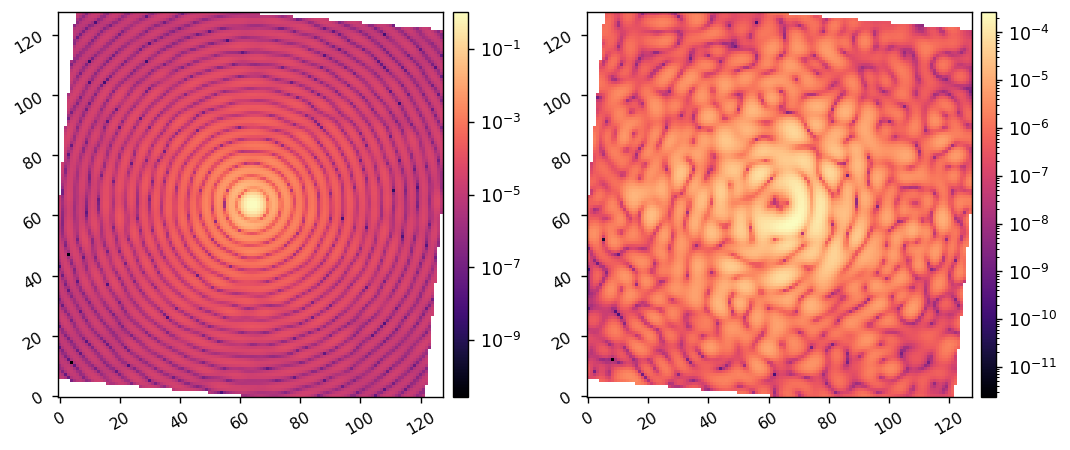

In [7]:
imshow2(ref_unocc_im, ref_im, lognorm=True)

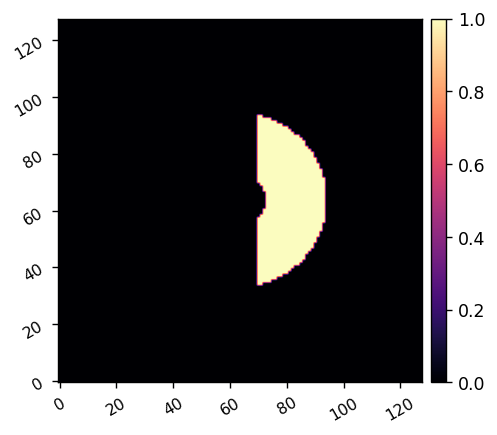

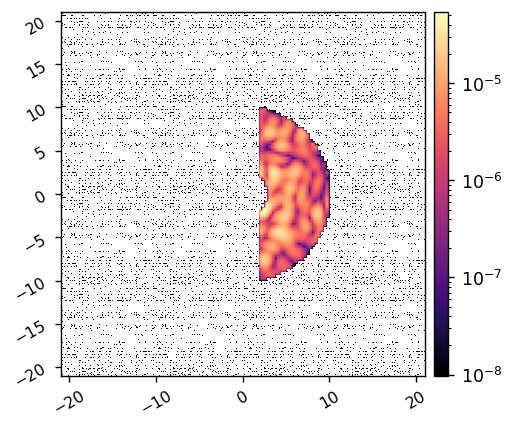

In [3]:
reload(lina.utils)
iwa = 3
owa = 10

control_mask = lina.utils.create_annular_focal_plane_mask(model, iwa, owa, edge=2, shift=(0,0), rotation=0, plot=True)
imshow1(ref_im*control_mask, lognorm=True, pxscl=model.psf_pixelscale_lamD)

In [5]:
reload(lina.efc)

model.reset_dm()
poke_modes = lina.utils.create_all_poke_modes(model.dm_mask)
jac = lina.efc.calibrate(model, xp.array(poke_modes), 1e-9, control_mask)

Calculating Jacobian: 


Exception ignored in: <function RandomState.__del__ at 0x7f8b9563c360>
Traceback (most recent call last):
  File "/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/cupy/random/_generator.py", line 66, in __del__
    curand.destroyGenerator(self._generator)
KeyboardInterrupt: 


In [5]:
from astropy.io import fits
jac = xp.array(fits.getdata('jac.fits'))

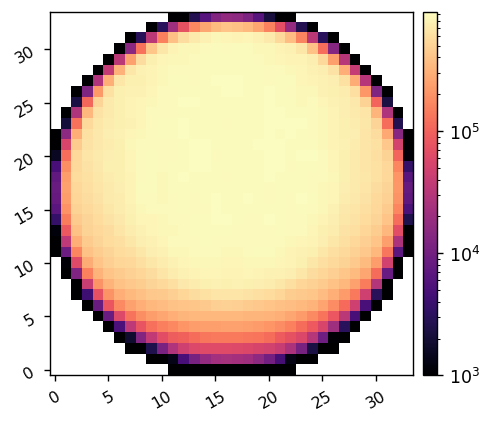

In [6]:
reload(lina.utils)
# response = lina.utils.map_acts_to_dm(xp.sqrt(((jac)**2).sum(axis=0)).get(), model.dm_mask)

responses = jac[::2] + 1j*jac[1::2]
dm_response = model.map_acts_to_dm(xp.sqrt(xp.sum(xp.abs(responses)**2, axis=0)))
imshow1(dm_response, lognorm=True, vmin=1e3)

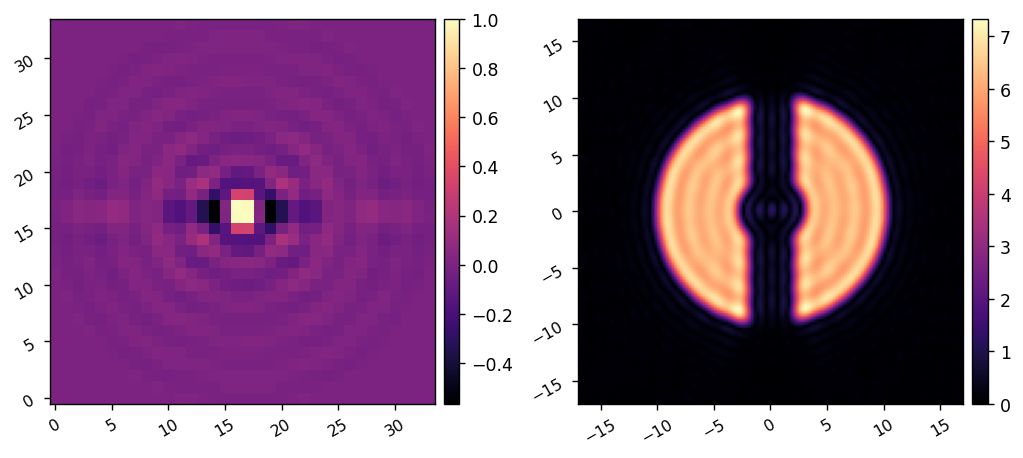

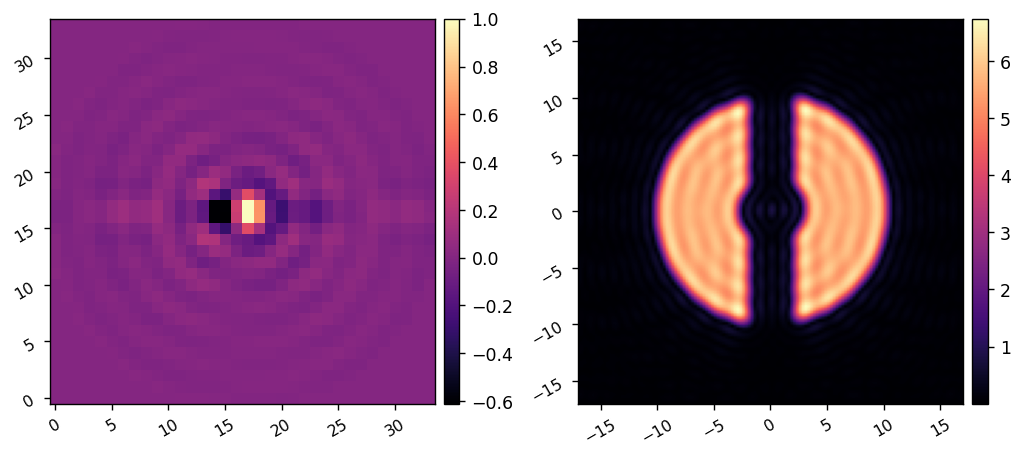

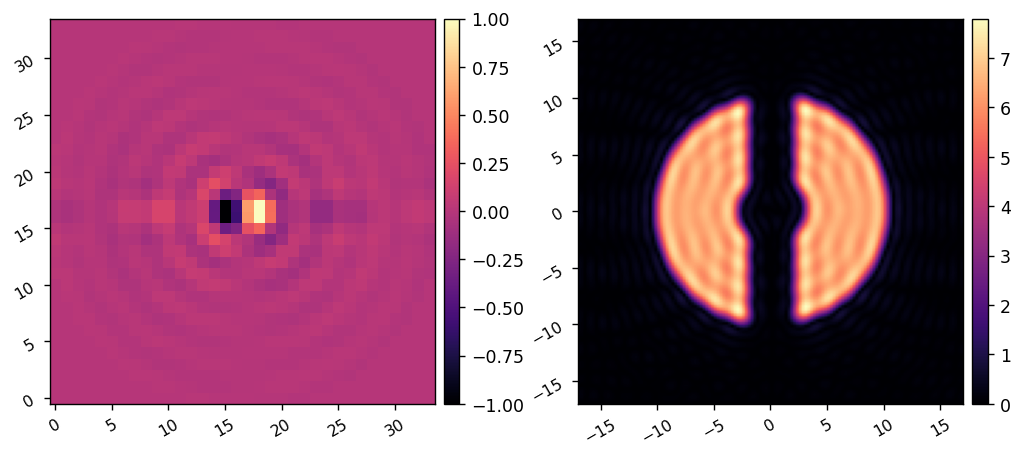

In [9]:
probe_amp = 2.5e-8
probes = probe_amp * lina.utils.create_fourier_probes(model, control_mask, fourier_sampling=0.2, nprobes=3, plot=True, calc_responses=True)

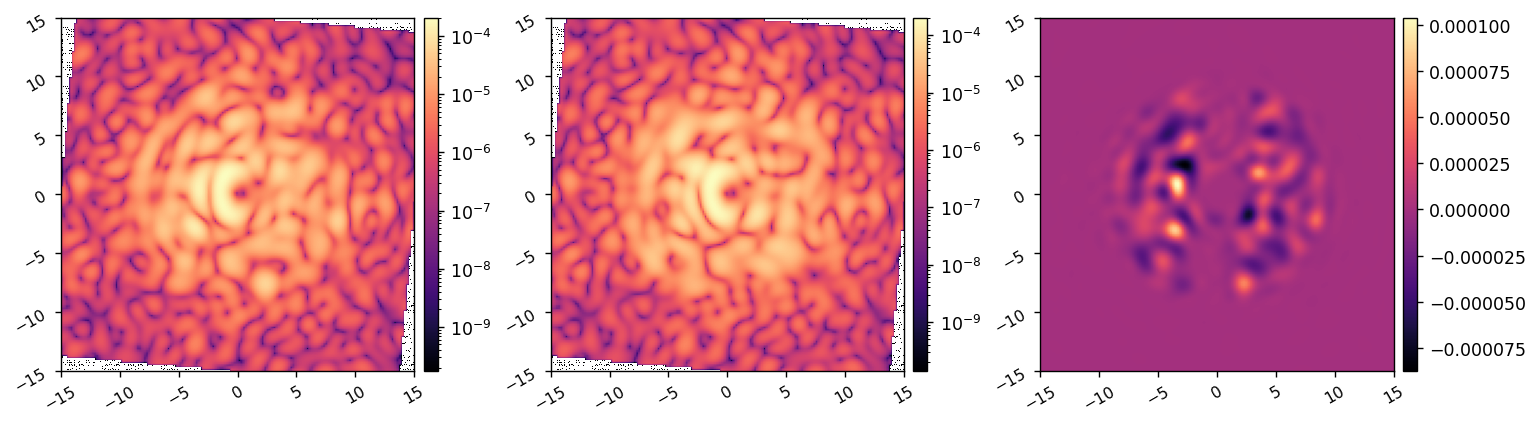

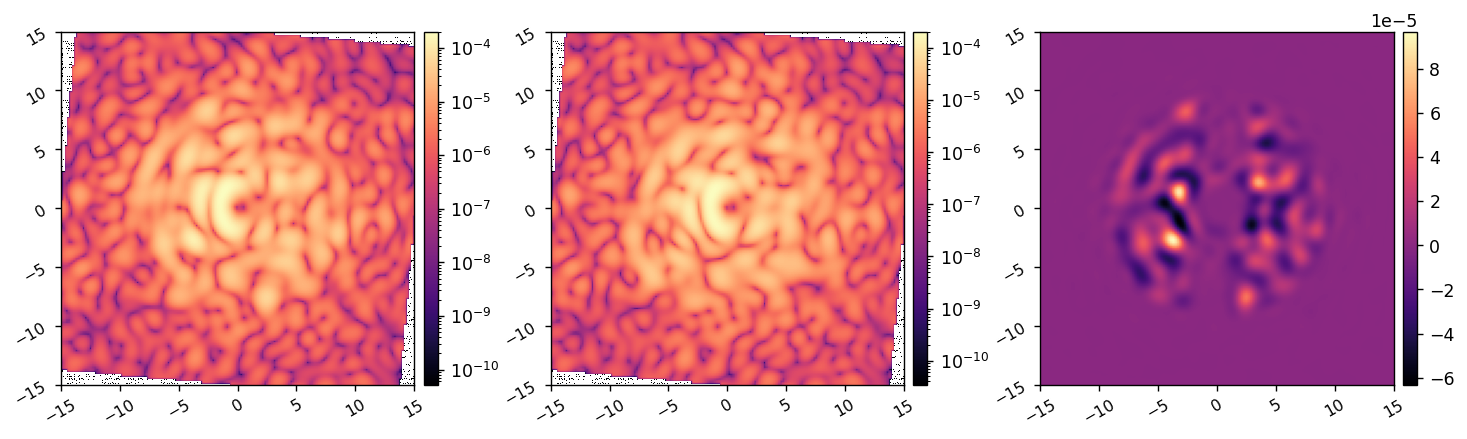

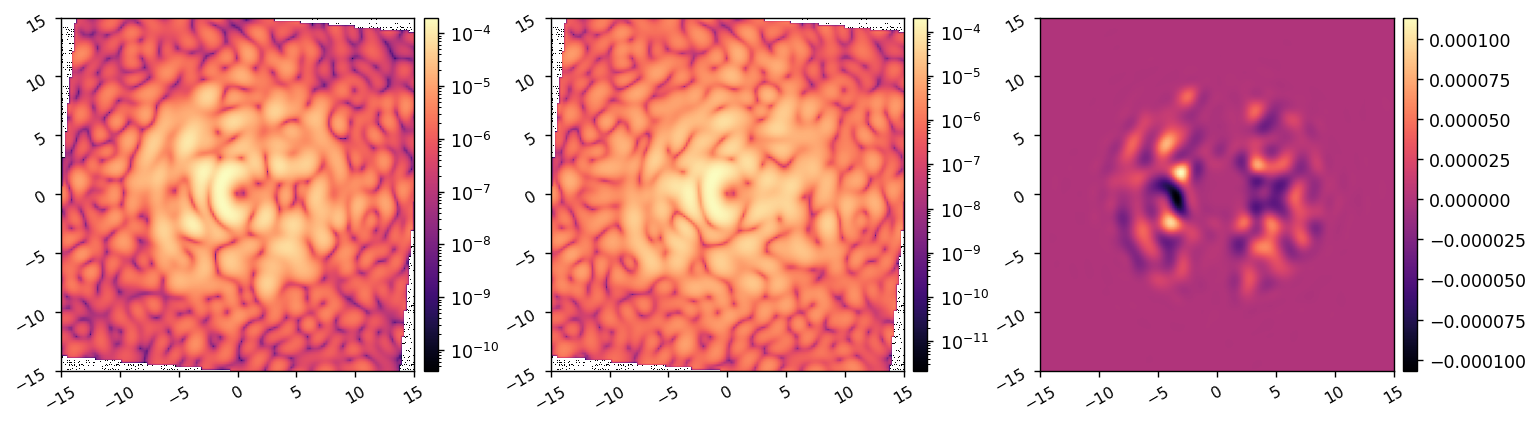

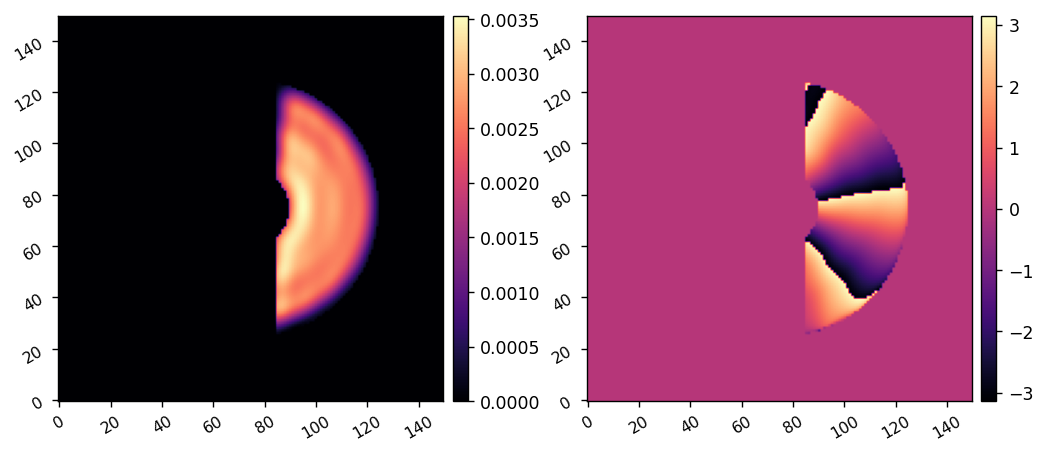

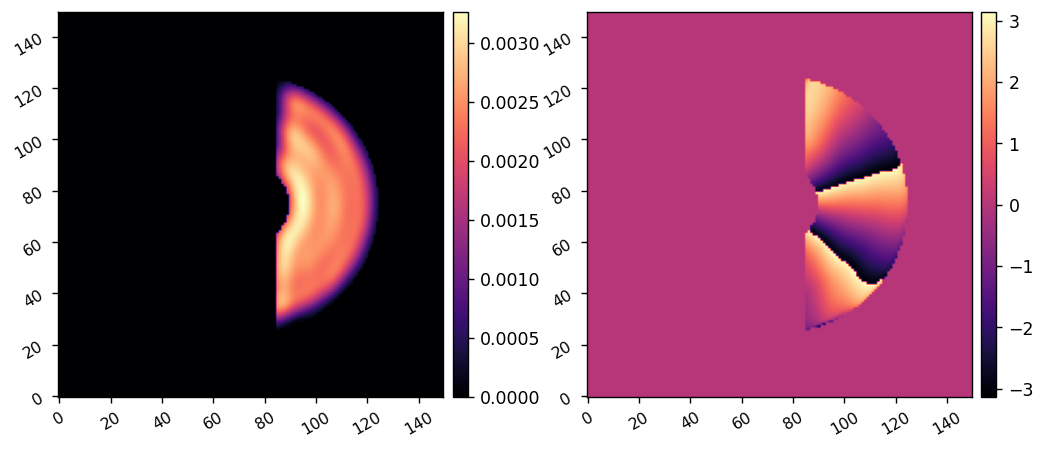

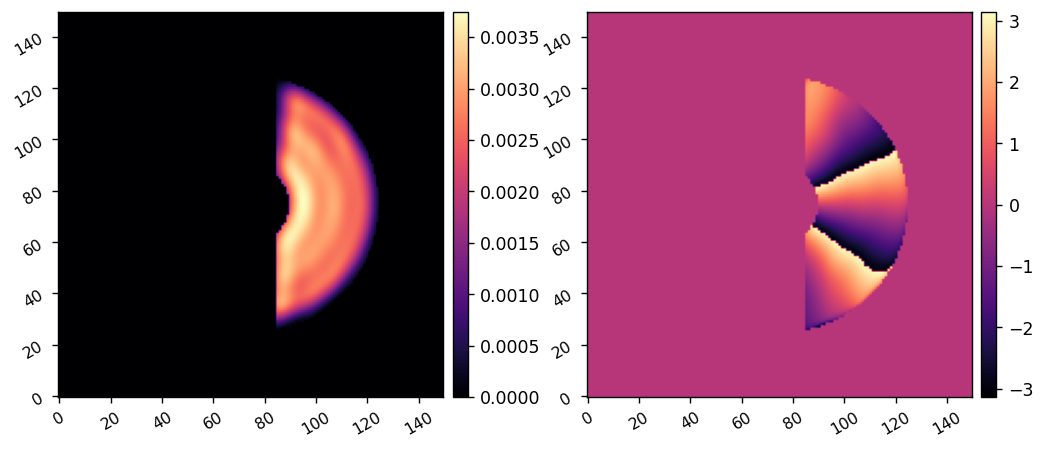

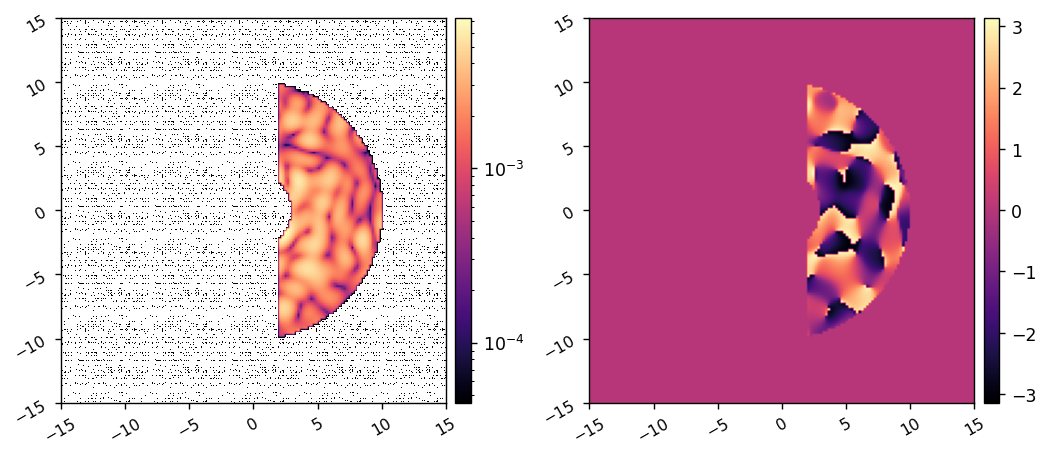

In [11]:
E_est = lina.pwp.run_pwp_bp(model, 
                               control_mask, 
                               probes,
                               use='J', jacobian=jac,
                               plot=True,
                               plot_est=True)

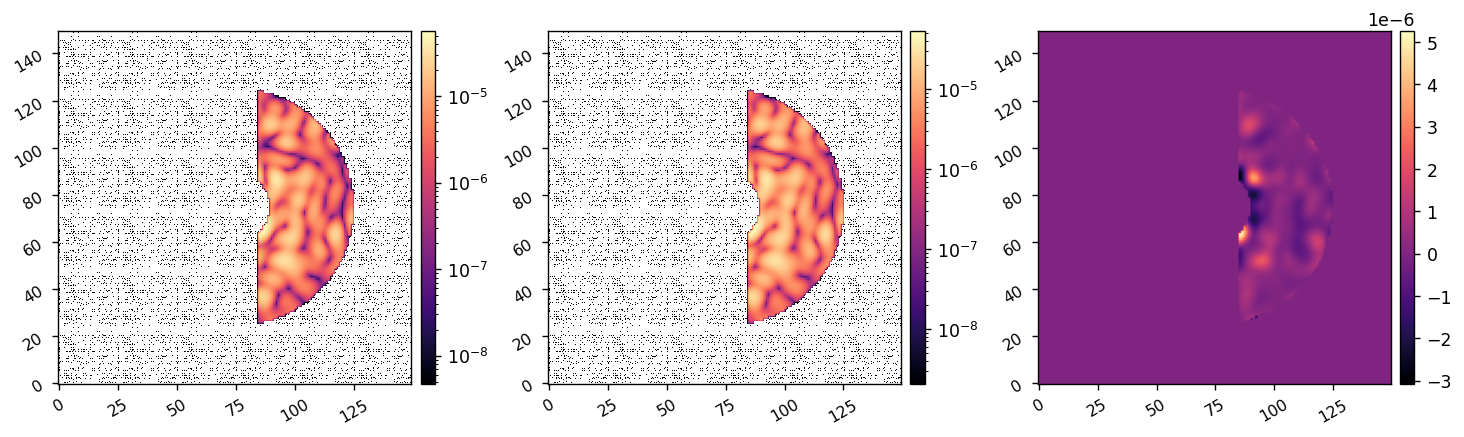

In [12]:
imshow3(ref_im*control_mask, xp.abs(E_est)**2, ref_im*control_mask - xp.abs(E_est)**2, lognorm1=True, lognorm2=True)

In [27]:
pwp_fun = lina.pwp.run_pwp_bp
pwp_kwargs = {
#     'sysi':model, 
#     'dark_mask':control_mask, 
    'probes':probes,
    'use':'J', 
    'jacobian':jac,
}

Beginning closed-loop EFC simulation.
Max singular value squared:	 5176885630106.765
alpha^2:			 896793413396.917
	Running iteration 1/2.


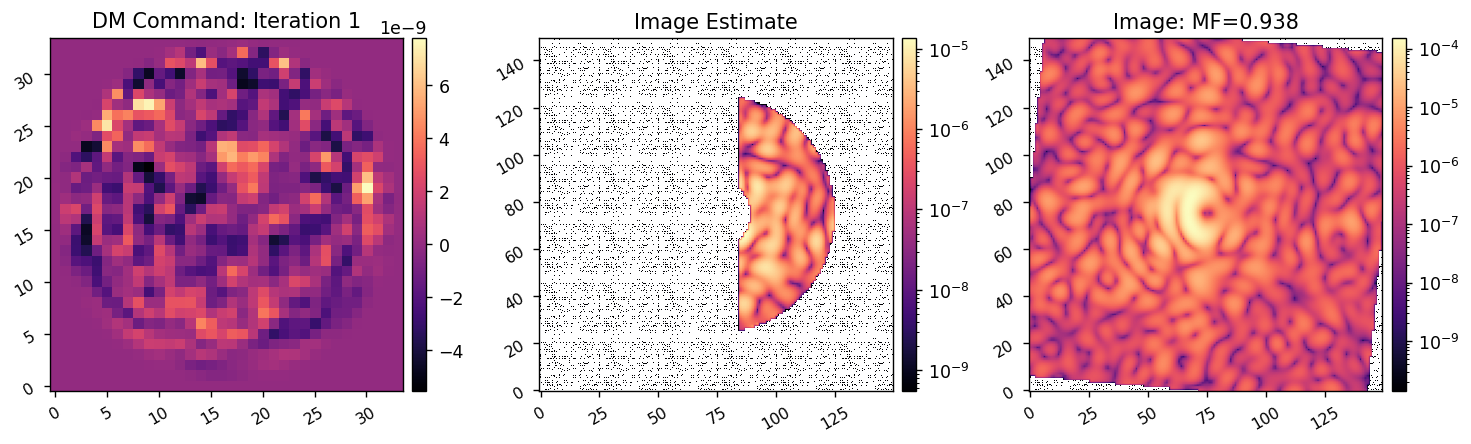

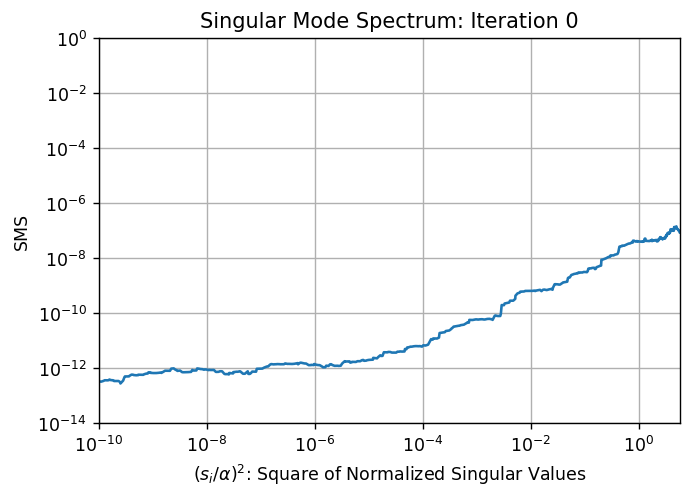

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


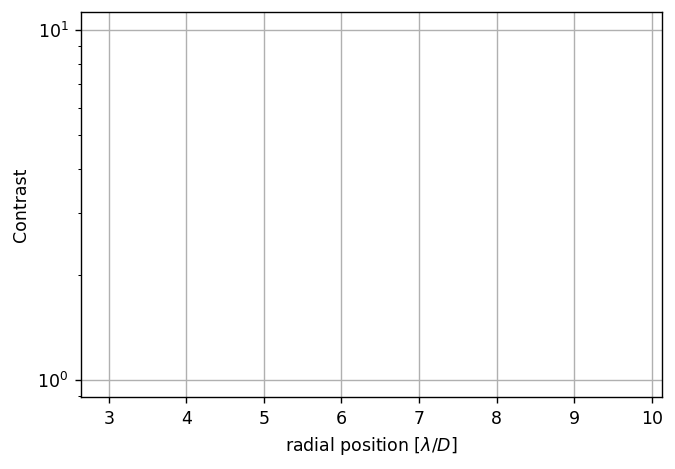

	Running iteration 2/2.


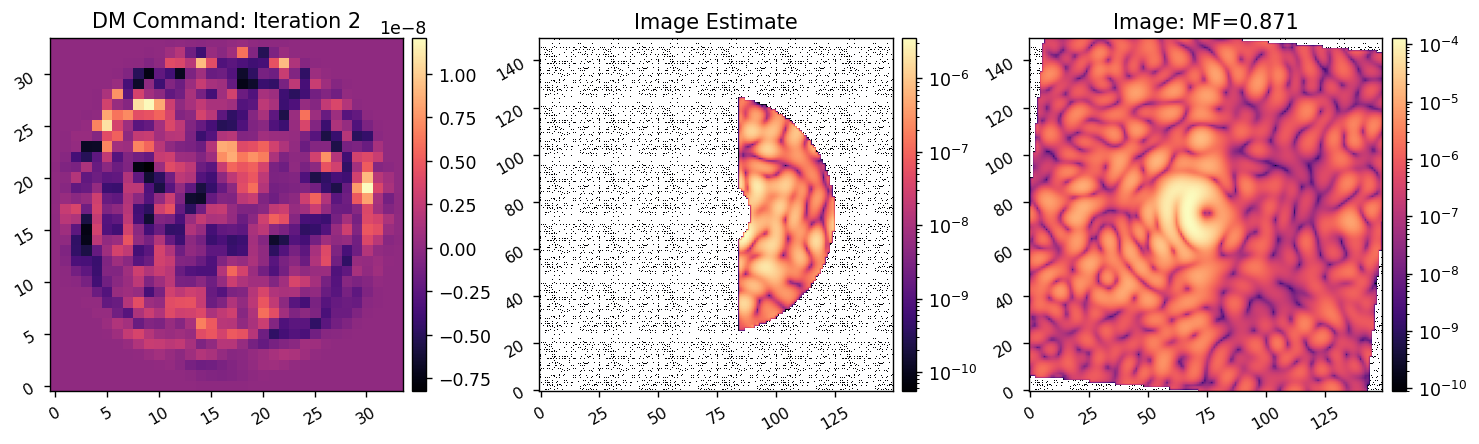

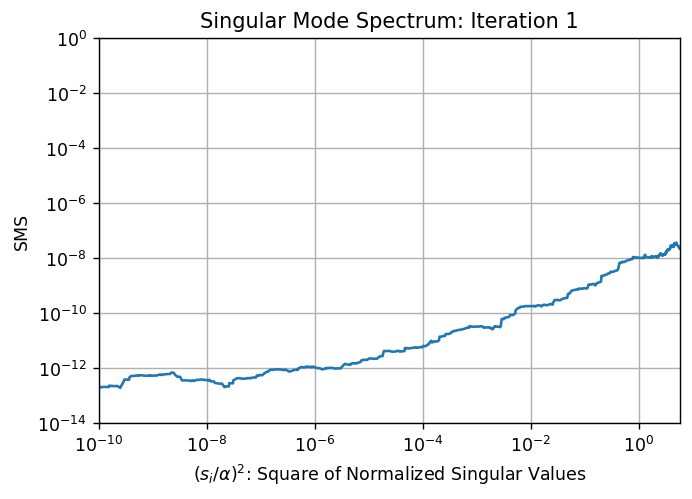

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


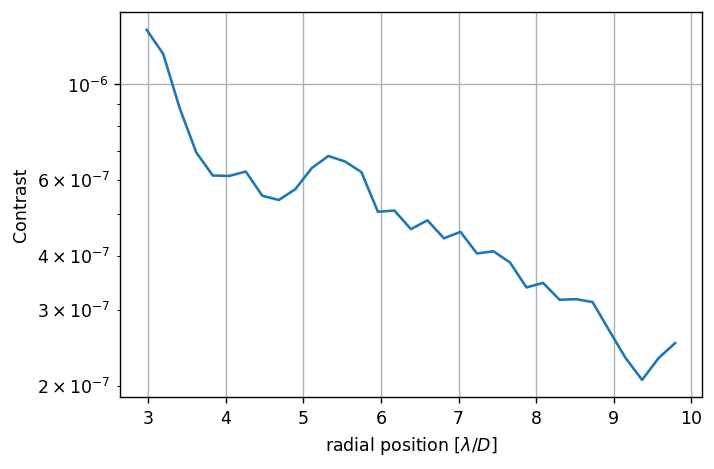

EFC completed in 21.837 sec.


In [29]:
reload(lina.efc)
model.reset_dm()

control_matrix = lina.utils.beta_reg(jac, -3)
    
images, efields, commands = lina.efc.run_efc_pwp(model, 
                                                pwp_fun,
                                                pwp_kwargs,
                                                jac,
                                                control_matrix,
                                                control_mask,
                                                Imax_unocc=1, # pre-normalized the model
                                                efc_loop_gain=0.5, 
                                                iterations=2, 
                                                plot_all=True, 
                                                plot_sms=True,
                                                 plot_radial_contrast=True)